# Hotel Rating Classification

**Business Objective:**

Examine how travelers are communicating their positive and negative experiences in online platforms for staying in a specific hotel.

Find out what are the attributes that travelers are considering while selecting a hotel. Which elements of the hotel influence more in forming a positive review or improves hotel brand image.

## EDA:

In [1]:
#Importing required libraries:

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns

import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,roc_curve




In [2]:
# Importing dataset:
df1 = pd.read_excel('hotel_reviews.xlsx')
df1.head()

Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5

In [3]:
#Describing the data set:
df1.describe().T

count      mean      std  min  25%  50%  75%  max
Rating  20491.0  3.952223  1.23303  1.0  3.0  4.0  5.0  5.0

In [4]:
#Information on dataset:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


In [5]:
#Shape of DataSet:
print(f'There are {df1.shape[0]} reviews and {df1.shape[1]} features in the dataset')

There are 20491 reviews and 2 features in the dataset


In [6]:
#Checking for missing values:
df1.isnull().sum()

Review    0
Rating    0
dtype: int64

In [7]:
#Checking for duplicate values:
num_duplicate_reviews=df1.duplicated().sum()
print(f'There are {num_duplicate_reviews} duplicate reviews in the dataset')

There are 0 duplicate reviews in the dataset


In [8]:
#Checking class imbalance
rating_counts = df1.Rating.value_counts()
rating_counts

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

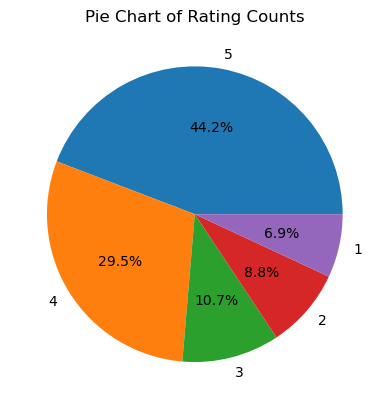

In [9]:
#Visualization of Rating Counts:
plt.pie(rating_counts,labels=rating_counts.index,autopct="%1.1f%%")
plt.title('Pie Chart of Rating Counts')
plt.show()

**Inferences:**

*   The majority of ratings are 5, followed by 4, then 3, then 2, then 1. This suggests that the majority of people are satisfied with their experience.
*   The ratings are not evenly distributed, as there is a large gap between the highest and lowest ratings. This suggests that there is a high variance in the quality and experience of the stay.
*   We can clearly notice class imbalance.
*   No duplicates or null values in data set.








In [10]:
#Calculating the count of words and length of Review in each review
df1["Word_Count"] = df1.Review.apply(lambda x : len(str(x).split(' ')))
df1["Review_Length"] = df1.Review.apply(len)

df1.head()

Review  Rating  Word_Count  \
0  nice hotel expensive parking got good deal sta...       4          89   
1  ok nothing special charge diamond member hilto...       2         252   
2  nice rooms not 4* experience hotel monaco seat...       3         219   
3  unique, great stay, wonderful time hotel monac...       5          91   
4  great stay great stay, went seahawk game aweso...       5         193   

   Review_Length  
0            593  
1           1689  
2           1427  
3            600  
4           1281

In [11]:
df1.describe().T

count        mean         std   min    25%    50%    75%  \
Rating         20491.0    3.952223    1.233030   1.0    3.0    4.0    5.0   
Word_Count     20491.0  106.375043  100.655267   9.0   50.0   79.0  126.0   
Review_Length  20491.0  725.245571  689.933070  44.0  339.0  537.0  859.0   

                   max  
Rating             5.0  
Word_Count      1933.0  
Review_Length  13501.0

In [12]:
#Creating a pivot table & graph to check avg no of words per rating category.
pt1 = pd.pivot_table(df1, values="Word_Count",index='Rating',aggfunc='mean')
fig1 = px.bar(pt1, x=pt1.index, y='Word_Count', title='Bar Chart : Rating Vs Avg Number of Words',width=600,height=500,color = 'Word_Count',color_continuous_scale= 'magenta')
fig1.show()


**Observations:**
*   We can see that there are few reviews that can be considered outliers based on their length.
*   Sometimes these kind of lengthy reviews provide us more information or they may containe noise and irrelevent details.
*   However, removing them will make our dataset more balanced and representative of the overall population of reviews and it will also make the model faster and more scalable.
*   We can also note that on an average, Positive reviews are more lengthy as compared to negative reviews.



In [13]:
# Reviewing the outliers:
df2 = df1.sort_values(by = 'Review_Length',ascending=False)
df2.head(20)

Review  Rating  Word_Count  \
7072   honest review visit 5/21-5/28 let begin saying...       3        1933   
7049   false start good vacation secrets__Ç, false st...       5        1757   
13003  awesome vacation sirenis punta cana arrival fl...       5        1641   
17777  fantastic return trip, firstly apology length ...       5        1610   
17800  wanted know afraid ask just 10 short days ago ...       4        1459   
6823   sunscape spectacular, august 2002 heard read r...       5        1385   
17953  great value great resort, family party hubbie ...       4        1437   
18911  vacation make husband stayed ocean blue septem...       3        1329   
6821   relaxing great time husband stayed sunscape ap...       4        1460   
2962   bavaro princess- incredible environment, overa...       4        1347   
20111  concerns not warranted breezes 25 years old ju...       4        1271   
2967   bravo bavaro knew not five-star hotel incredib...       4        1207   
3727   wed bambu, husband married riu bambu 18th 2006...       4        1252   
3211   melia caribe wonderful, just returned wonderfu...       5        1198   
18631  n't come food, girlfriend stayed majestic febr...       2        1040   
16617  perfect days paradise, waited home write guest...       5        1039   
17966  beutiful resort horrible service dates stay ju...       2        1111   
17759  3 weeks bliss, husband just returned 3 week ho...       5        1075   
7027   6/1/06 6/7/06 great time n't, ok think importa...       4        1076   
14765  star resort world country daughter just return...       4        1009   

       Review_Length  
7072           13501  
7049           12762  
13003          11014  
17777          10420  
17800          10062  
6823            9748  
17953           9712  
18911           9405  
6821            9351  
2962            8953  
20111           8692  
2967            8607  
3727            8323  
3211            7993  
18631           7988  
16617           7924  
17966           7632  
17759           7579  
7027            7364  
14765           7296

Reading lengthy reviews:

In [14]:
df2.Review.iloc[0]

"honest review visit 5/21-5/28 let begin saying heard secrets couple work went resort year returned raving experiences, all-inclusive regular cruise traveler past 4 years decided based word-of-mouth secrets place try.i read posts site daily, review written resort scoured eyes, reviews gotten good suspected staff secrets writing, fact person posted review claimed saw staff members reading posting forum, ca n't say stay excellence club saw type activity going wo n't past hotel ratings high posting positive reviews.in case read totally honest review secrets felt all-inclusive experience, end review include link photo page think enjoy.i booked trip judy maria travel internet, no travel agent travel site pop did search booking resort, went site saw photos judy maria resort chumming general manager, felt dealing travel agents knew resort took chance booking, great gamble, maria gave great price suggested perfect room location took travel worries hands, admit nervous n't room wanted helicopte

### Pre-Processing Data:

In [15]:
# Removing Lengthy Reviews (Outliers):
df1 = df1.loc[df1['Review_Length']<=2000]
df1.head()

Review  Rating  Word_Count  \
0  nice hotel expensive parking got good deal sta...       4          89   
1  ok nothing special charge diamond member hilto...       2         252   
2  nice rooms not 4* experience hotel monaco seat...       3         219   
3  unique, great stay, wonderful time hotel monac...       5          91   
4  great stay great stay, went seahawk game aweso...       5         193   

   Review_Length  
0            593  
1           1689  
2           1427  
3            600  
4           1281

In [16]:
#Shape of DataSet:
print(f'There are {df1.shape[0]} reviews and {df1.shape[1]} features in the dataset')

There are 19580 reviews and 4 features in the dataset


In [17]:
#Converting data to lower case:
df1.Review.apply(lambda x: " ".join(word.lower() for word in x.split(' ')))
df1.head()

Review  Rating  Word_Count  \
0  nice hotel expensive parking got good deal sta...       4          89   
1  ok nothing special charge diamond member hilto...       2         252   
2  nice rooms not 4* experience hotel monaco seat...       3         219   
3  unique, great stay, wonderful time hotel monac...       5          91   
4  great stay great stay, went seahawk game aweso...       5         193   

   Review_Length  
0            593  
1           1689  
2           1427  
3            600  
4           1281

In [18]:
#Removing numerical values & punctuation marks:
#import re

df1.Review = df1.Review.apply(lambda x : ' '.join(re.sub("[0-9" "]+"," ",x) for x in x.split(' ')))
df1.Review = df1.Review.str.replace('[^\w\s]','')
df1.Review = df1.Review.str.replace('\n',' ')
df1.Review = df1.Review.str.replace('_','')
df1.Review = df1.Review.str.replace('\\','')

df1.head()

C:\Users\Anup0\AppData\Local\Temp\ipykernel_3860\1367728986.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\Anup0\AppData\Local\Temp\ipykernel_3860\1367728986.py:8: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



Review  Rating  Word_Count  \
0  nice hotel expensive parking got good deal sta...       4          89   
1  ok nothing special charge diamond member hilto...       2         252   
2  nice rooms not   experience hotel monaco seatt...       3         219   
3  unique great stay wonderful time hotel monaco ...       5          91   
4  great stay great stay went seahawk game awesom...       5         193   

   Review_Length  
0            593  
1           1689  
2           1427  
3            600  
4           1281

**Stop Words:**

They are words that are very common and do not carry much meaning or information in a text, such as “the”, “a”, “an”, “in”, etc.

They are often ignored by search engines and NLP tools because they can take up space and processing time without adding much value.

In [19]:
#Importing Stop Words:
f= open("stop.txt","r")
stopw = f.read()
stopw=list(stopw)


#Removing Stop Words:
df1["Review"] = df1["Review"].apply(lambda x: ' '.join(x for x in x.split() if x not in stopw))
df1["Word_Count"] = df1["Review"].apply(lambda x : len(str(x).split()))

df1.head()

Review  Rating  Word_Count  \
0  nice hotel expensive parking got good deal sta...       4          86   
1  ok nothing special charge diamond member hilto...       2         242   
2  nice rooms not experience hotel monaco seattle...       3         205   
3  unique great stay wonderful time hotel monaco ...       5          88   
4  great stay great stay went seahawk game awesom...       5         189   

   Review_Length  
0            593  
1           1689  
2           1427  
3            600  
4           1281

In [20]:
#New dataframe with reviews of rating = 5
df_pos = df1.loc[df1["Rating"].isin([5])]


#New dataframe with reviews of rating = 1
df_neg = df1.loc[df1["Rating"].isin([1])]

### Word Clouds:

A word cloud is a collection or cluster of words depicted in different sizes.

The bigger and bolder the word appears, the more often it is mentioned in a text and the more important it is.

***Positive WordCloud:***

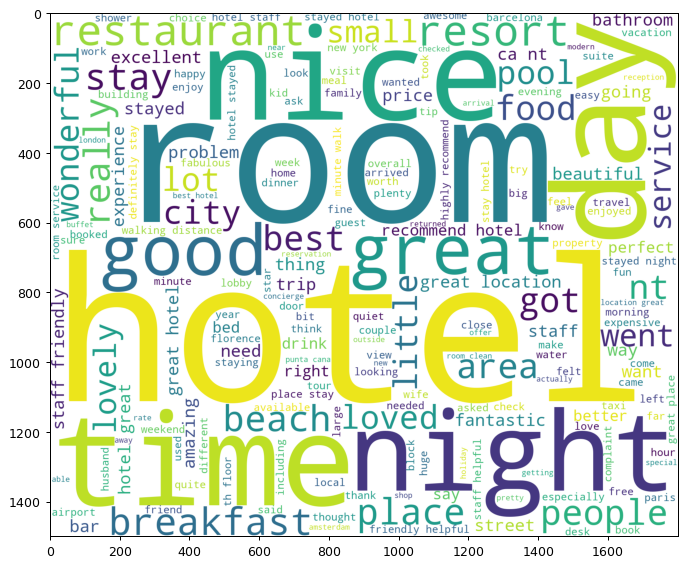

In [21]:
#Wordcloud for Positive Reviews:
string_Total = " ".join(df_pos['Review'])
plt.figure(figsize=(9,9),dpi=90)
wordcloud = WordCloud(background_color= 'white', width = 1800, height = 1500).generate(string_Total)
plt.imshow(wordcloud)
plt.show()

***Negative WordCloud:***

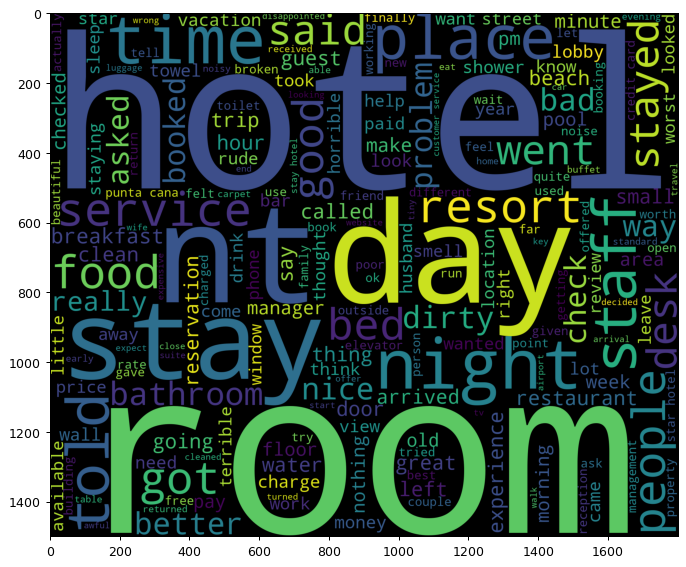

In [22]:
#Wordcloud for Negative Reviews:
string_Total = " ".join(df_neg['Review'])
plt.figure(figsize=(9,9),dpi=90)
wordcloud = WordCloud(background_color= 'black', width = 1800, height = 1500).generate(string_Total)
plt.imshow(wordcloud)
plt.show()

### N-grams:

**N-grams** are contiguous sequences of n words extracted from text for language processing and analysis. An n-gram can be as short as a single word (unigram) or as long as multiple words (bigram, trigram, etc.)

N-grams are useful in NLP for various purposes, such as:

*   To extract features from text data, such as sentiment analysis, text classification, and language modeling.
*   To predict the next word or phrase in a text, based on the probability of its occurrence given the previous words or phrases.
*   To correct spelling errors or typos in a text, based on the similarity and frequency of the words or phrases.

#### Uni-gram:

***Positive Uni-grams:***

In [23]:
# Uni-grams for positive reviews with rating = 5:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_pos['Review'])
word_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'occurrences':np.asarray(X.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences']) #Frequency in entire df
word_freq_df.sort_values(by = 'occurrences', ascending=False,inplace = True)
word_freq_df.head()


term  occurrences  frequency
16052  hotel        20734   0.029446
28117   room        10879   0.015450
14529  great         9768   0.013872
22530    not         7341   0.010426
31085  staff         7272   0.010328

In [24]:
# Bar chart of most common positive uni-grams:
fig = px.bar(word_freq_df.head(40), x='term', y='occurrences',color = 'occurrences',color_continuous_scale= 'magenta')
fig.update_layout(xaxis_tickangle=90)
fig.show()

***Negative Uni-grams:***

In [25]:
# Uni-grams for negative reviews with rating = 1:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_neg['Review'])
word_freq_df = pd.DataFrame({'term': vectorizer.get_feature_names_out(), 'occurrences':np.asarray(X.sum(axis=0)).ravel().tolist()})
word_freq_df['frequency'] = word_freq_df['occurrences']/np.sum(word_freq_df['occurrences'])
word_freq_df.sort_values(by = 'occurrences', ascending=False,inplace = True)
word_freq_df.head()


term  occurrences  frequency
5840   hotel         3283   0.025905
8130     not         3168   0.024997
10378   room         2808   0.022157
8185      nt         1390   0.010968
8053      no         1286   0.010147

In [26]:
# Bar chart of most common negative uni-grams:
fig = px.bar(word_freq_df.head(40), x='term', y='occurrences',color = 'occurrences',color_continuous_scale= 'magenta')
fig.update_layout(xaxis_tickangle=90)
fig.show()

#### Bi-gram:

In [27]:
#Function that will accept corpus as input and return top n Bi-grams:

def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2), max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

***Positive Bi-grams:***

In [28]:
#Positive review Bi-grams:
bigrams = get_top_n2_words(df_pos['Review'], n=200)# top 200
bigrams = pd.DataFrame(bigrams)
bigrams.columns = ["Bi-gram", "Freq"]
bigrams.head(10)

Bi-gram  Freq
0            did nt  1280
1    great location   945
2    staff friendly   912
3       great hotel   902
4             ca nt   818
5           did not   806
6   recommend hotel   803
7       hotel great   758
8  friendly helpful   719
9  walking distance   688

In [29]:
#Bar chart of most common positive Bi-grams:
fig = px.bar(bigrams.head(40), x='Bi-gram', y='Freq',color = 'Freq',color_continuous_scale= 'turbo')
fig.update_layout(xaxis_tickangle=90)
fig.show()

***Negative Bi-grams:***

In [30]:
#Negative review Bi-grams:
bigrams = get_top_n2_words(df_neg['Review'], n=200)# top 200
bigrams = pd.DataFrame(bigrams)
bigrams.columns = ["Bi-gram", "Freq"]
bigrams.head(10)

Bi-gram  Freq
0           did not   404
1            did nt   343
2          room not   128
3          not stay   128
4        punta cana   121
5         hotel not   105
6       credit card    99
7        star hotel    99
8        stay hotel    91
9  customer service    89

In [31]:
#Bar chart of most common negative Bi-grams:
fig = px.bar(bigrams.head(40), x='Bi-gram', y='Freq',color = 'Freq',color_continuous_scale= 'turbo')
fig.update_layout(xaxis_tickangle=90)
fig.show()

#### Tri-gram:

In [32]:
#Function that will accept corpus as input and return top n Tri-grams:

def get_top_n3_words(corpus, n=None):
    vec2 = CountVectorizer(ngram_range=(3,3), max_features=2000).fit(corpus)
    bag_of_words = vec2.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec2.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


***Positive Tri-grams:***

In [33]:
#Positive review Tri-grams:
trigrams = get_top_n3_words(df_pos['Review'], n=200)# top 200
trigrams = pd.DataFrame(trigrams)
trigrams.columns = ["Tri-gram", "Freq"]
trigrams.head(10)

Tri-gram  Freq
0  staff friendly helpful   353
1    hotel great location   290
2  highly recommend hotel   252
3           room th floor   184
4              ca nt wait   175
5       great hotel great   165
6        great place stay   161
7          flat screen tv   126
8            old san juan   112
9    hotel staff friendly   104

In [34]:
#Bar chart of most common positive Tri-grams:
fig = px.bar(trigrams.head(40), x='Tri-gram', y='Freq',color = 'Freq',color_continuous_scale= 'plasma')
fig.update_layout(xaxis_tickangle=90)
fig.show()

***Negative Tri-grams:***

In [35]:
#Negative review Tri-grams:
trigrams = get_top_n3_words(df_neg['Review'], n=200)# top 200
trigrams = pd.DataFrame(trigrams)
trigrams.columns = ["Tri-gram", "Freq"]
trigrams.head(10)

Tri-gram  Freq
0         did not work    51
1          did nt work    41
2  not recommend hotel    37
3   worst hotel stayed    28
4       not stay hotel    22
5          room did nt    20
6          did nt want    19
7       room not ready    19
8         no hot water    18
9         room did not    17

In [36]:
#Bar chart of most common negative Tri-grams:
fig = px.bar(trigrams.head(40), x='Tri-gram', y='Freq',color = 'Freq',color_continuous_scale= 'plasma')
fig.update_layout(xaxis_tickangle=90)
fig.show()

### TF-IDF :

**TF-IDF** stands for term frequency-inverse document frequency, and it is a measure of how important a word is to a document in a corpus.

In [37]:
#Term Frequency – Inverse Document Frequency (TF-IDF):

vectorizer = TfidfVectorizer(stop_words=stopw, ngram_range=(1,3), max_features= 10000, max_df = 0.5, smooth_idf=True,use_idf=True)
#max_features= 1500 : keep top 1500 words
#max_df = 0.5 : Ignore the words that appear in more than 50% of the documents
#min_df = 50 : Ignore the words that appear in less than 50 documents
#ngram_range=(1,3) : Include unigrams,bigrams and trigrams

doc_vec = vectorizer.fit_transform(df1["Review"])
names_features = vectorizer.get_feature_names_out()
dense = doc_vec.todense()
denselist = dense.tolist()

tfidf = pd.DataFrame(denselist, columns = names_features)
tfidf

aaa  abc  ability  abit  able  able check  able make  able sleep  \
0      0.000000  0.0      0.0   0.0   0.0         0.0        0.0         0.0   
1      0.000000  0.0      0.0   0.0   0.0         0.0        0.0         0.0   
2      0.000000  0.0      0.0   0.0   0.0         0.0        0.0         0.0   
3      0.000000  0.0      0.0   0.0   0.0         0.0        0.0         0.0   
4      0.000000  0.0      0.0   0.0   0.0         0.0        0.0         0.0   
...         ...  ...      ...   ...   ...         ...        ...         ...   
19575  0.140619  0.0      0.0   0.0   0.0         0.0        0.0         0.0   
19576  0.000000  0.0      0.0   0.0   0.0         0.0        0.0         0.0   
19577  0.000000  0.0      0.0   0.0   0.0         0.0        0.0         0.0   
19578  0.000000  0.0      0.0   0.0   0.0         0.0        0.0         0.0   
19579  0.000000  0.0      0.0   0.0   0.0         0.0        0.0         0.0   

       able stay  able use  ...  youçéèe   yr  yr old  yrs  yuck  yummy  \
0            0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   
1            0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   
2            0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   
3            0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   
4            0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   
...          ...       ...  ...      ...  ...     ...  ...   ...    ...   
19575        0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   
19576        0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   
19577        0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   
19578        0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   
19579        0.0       0.0  ...      0.0  0.0     0.0  0.0   0.0    0.0   

       yunque  zero  zone  zoo  
0         0.0   0.0   0.0  0.0  
1         0.0   0.0   0.0  0.0  
2         0.0   0.0   0.0  0.0  
3         0.0   0.0   0.0  0.0  
4         0.0   0.0   0.0  0.0  
...       ...   ...   ...  ...  
19575     0.0   0.0   0.0  0.0  
19576     0.0   0.0   0.0  0.0  
19577     0.0   0.0   0.0  0.0  
19578     0.0   0.0   0.0  0.0  
19579     0.0   0.0   0.0  0.0  

[19580 rows x 10000 columns]

In [38]:
#Validation of TF-IDF:
df1["Review"][4]
df2 = df1.copy()

## Sentiment Analysis:

###Preparing Dataset:

In [39]:
# Function to calculate Subjectivity & Polarity:
def sentiment_analysis(text):
    sentiment = TextBlob(text).sentiment
    return pd.Series([sentiment.subjectivity, sentiment.polarity])


In [40]:
# Adding Subjectivity & Polarity to df1:
df2[["subjectivity", "polarity"]] = df2['Review'].apply(sentiment_analysis)
df2.head()

Review  Rating  Word_Count  \
0  nice hotel expensive parking got good deal sta...       4          86   
1  ok nothing special charge diamond member hilto...       2         242   
2  nice rooms not experience hotel monaco seattle...       3         205   
3  unique great stay wonderful time hotel monaco ...       5          88   
4  great stay great stay went seahawk game awesom...       5         189   

   Review_Length  subjectivity  polarity  
0            593      0.687000  0.208744  
1           1689      0.523295  0.227204  
2           1427      0.605208  0.294420  
3            600      0.691228  0.504825  
4           1281      0.629396  0.384615

In [41]:
#Polarity & Subjectivity distribution for each rating category:
fig = px.box(df2, x='Rating', y='polarity', title=('Distribution of polarity in the range of [-1,1] for each rating category'))
fig.show()
fig2 = px.box(df2, x='Rating', y='subjectivity', title=('Distribution of subjectivity in the range of [0,1] for each rating category'))
fig2.show()

In [42]:
#Function to calculate sentiment:
def sentiment_cal(df2):
    if df2['Rating'] > 4 and df2['subjectivity'] >0.3 and df2['polarity'] >0.5:
        return 'Positive'
    elif df2['Rating'] < 3 and df2['polarity'] <0:
        return 'Negative'
    elif df2['Rating'] == 3 and df2['polarity'] <0.3:
        return 'Neutral'
    else:
        return 'drop'


**Adding Target Feature:**

In [43]:
#Creating sentiment column:
df2['Sentiment'] = df2.apply(sentiment_cal,axis=1)
df2.head(10)

Review  Rating  Word_Count  \
0  nice hotel expensive parking got good deal sta...       4          86   
1  ok nothing special charge diamond member hilto...       2         242   
2  nice rooms not experience hotel monaco seattle...       3         205   
3  unique great stay wonderful time hotel monaco ...       5          88   
4  great stay great stay went seahawk game awesom...       5         189   
5  love monaco staff husband stayed hotel crazy w...       5         130   
6  cozy stay rainy city husband spent nights mona...       5          98   
7  excellent staff housekeeping quality hotel cho...       4          85   
8  hotel stayed hotel monaco cruise rooms generou...       5          58   
9  excellent stayed hotel monaco past we delight ...       5          35   

   Review_Length  subjectivity  polarity Sentiment  
0            593      0.687000  0.208744      drop  
1           1689      0.523295  0.227204      drop  
2           1427      0.605208  0.294420   Neutral  
3            600      0.691228  0.504825  Positive  
4           1281      0.629396  0.384615      drop  
5           1002      0.614583  0.243056      drop  
6            748      0.631890  0.366661      drop  
7            597      0.788889  0.562963      drop  
8            419      0.576786  0.312946      drop  
9            271      0.534066  0.286355      drop

In [44]:
#Checking for class imbalance:
df2.Sentiment.value_counts()

drop        15366
Neutral      1670
Positive     1408
Negative     1136
Name: Sentiment, dtype: int64

In [45]:
df2=df2.loc[df2.Sentiment != 'drop']
df2.head(20)

Review  Rating  Word_Count  \
2   nice rooms not experience hotel monaco seattle...       3         205   
3   unique great stay wonderful time hotel monaco ...       5          88   
13  nice hotel not nice staff hotel lovely staff q...       3          65   
19  hmmmmm say really high hopes hotel monaco chos...       3         151   
21  excellent stay delightful surprise stay monaco...       5          21   
25  nt mind noise place great read reviews noise u...       3          66   
27  met expectations centrally located hotel block...       3          69   
40  bad choice booked hotel hot wire called immedi...       1         117   
42  warwick bad good reviews warwick shocks staff ...       2          24   
44  austin powers decor familiar hotel seattlewher...       2          36   
46  pay read reviews booked knew getting mind nt s...       3          68   
47  not bad location unmatchable price range simpl...       3          67   
48  remarkable hotel needed days booked inn based ...       5          54   
50  excellent way stayed inn market memorial day w...       5          45   
53  great hotel great hotel good sized clean rooms...       5          28   
54  expensive not biz travellers simple fact hotel...       3         125   
56  okay not amazing husband stayed weekend night ...       3          60   
65  hated inn terrible roomservice horrible staff ...       1          16   
67  ace not place husband stayed ace hotel seattle...       3         214   
73  perfect way stayed ace seattle short time augu...       5          52   

    Review_Length  subjectivity  polarity Sentiment  
2            1427      0.605208  0.294420   Neutral  
3             600      0.691228  0.504825  Positive  
13            417      0.705556 -0.091667   Neutral  
19           1025      0.475012  0.105758   Neutral  
21            178      0.781250  0.596875  Positive  
25            482      0.575926  0.251852   Neutral  
27            538      0.501852  0.065625   Neutral  
40            861      0.578571 -0.027839  Negative  
42            153      0.633333 -0.230000  Negative  
44            268      0.533333 -0.043056  Negative  
46            481      0.420563  0.111688   Neutral  
47            452      0.574887  0.195641   Neutral  
48            413      0.641667  0.525000  Positive  
50            305      0.644228  0.511364  Positive  
53            199      0.710000  0.608333  Positive  
54            858      0.475000  0.024603   Neutral  
56            407      0.694444  0.239120   Neutral  
65            133      0.725000 -0.633333  Negative  
67           1441      0.615054  0.172715   Neutral  
73            351      0.644872  0.518590  Positive

In [46]:
#Polarity & Subjectivity distribution for each rating category:
fig = px.box(df2, x='Rating', y='polarity', title=('Distribution of polarity in the range of [-1,1] for rating category'))
fig.show()

In [47]:
le = LabelEncoder()
df2['Sentiment'] = le.fit_transform(df2['Sentiment'])
df2=df2[['Review','Sentiment']]
df2 = df2.sample(frac=1)
df2.reset_index(drop=True,inplace=True)
df2.head()

Review  Sentiment
0  hotel hell stayed fall seeing reviews online e...          0
1  wonderfull days nadia hotel stay nadia hotel d...          2
2  oh dont star hotel group hotel ashamed read re...          0
3  nice try stayed hotel day grand opening booked...          1
4  not great stay away lacks charm secondly right...          0

In [48]:
# Spliting dataframe into dependent & independent var:
X = df2.iloc[:,0]
y = df2.iloc[:,-1]

In [49]:
# Spliting dataframe into Train & Test:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

###Preparing Model:

In [50]:
# Preparing RandomForestClassifier model and fitting data:
vec = TfidfVectorizer(stop_words=stopw, ngram_range=(1,3), max_features= 1000, max_df = 0.5, smooth_idf=True,use_idf=True)
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,max_leaf_nodes=25,random_state=42)
sentiment_model = Pipeline([('vectorizer',vec),('classifier',rf)])
sentiment_model.fit(X_train,y_train)

#making predictions on test & train dataset and calculating accuracy:
y_pred_train = sentiment_model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy of the train dataset: {acc_train:.2f}')

y_pred = sentiment_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f'Accuracy of the test dataset: {acc_test:.2f}')

Accuracy of the train dataset: 0.87
Accuracy of the test dataset: 0.84


In [51]:
# Preparing LogisticRegression model and fitting data:
vec = TfidfVectorizer()
clf = LogisticRegression(solver='liblinear')
sentiment_model = Pipeline([('vectorizer',vec),('classifier',clf)])
sentiment_model.fit(X_train,y_train)

#making predictions on test & train dataset and calculating accuracy:
y_pred_train = sentiment_model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy of the train dataset: {acc_train:.2f}')

y_pred = sentiment_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f'Accuracy of the test dataset: {acc_test:.2f}')

Accuracy of the train dataset: 0.97
Accuracy of the test dataset: 0.90


In [52]:
# Preparing svm model and fitting data:
vec = TfidfVectorizer(stop_words=stopw, ngram_range=(1,3), max_features= 1000, max_df = 0.5, smooth_idf=True,use_idf=True)
from sklearn.svm import SVC
svc = SVC(C=7, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.004,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
sentiment_model = Pipeline([('vectorizer',vec),('classifier',svc)])
sentiment_model.fit(X_train,y_train)

#making predictions on test & train dataset and calculating accuracy:
y_pred_train = sentiment_model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy of the train dataset: {acc_train:.2f}')

y_pred = sentiment_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f'Accuracy of the test dataset: {acc_test:.2f}')

Accuracy of the train dataset: 0.85
Accuracy of the test dataset: 0.83


In [53]:
# Preparing LogisticRegression model and fitting data:
vec = TfidfVectorizer(ngram_range=(1,3), max_features= 3000, max_df = 0.5, smooth_idf=True,use_idf=True)
clf = LogisticRegression(solver='liblinear')
sentiment_model = Pipeline([('vectorizer',vec),('classifier',clf)])
sentiment_model.fit(X_train,y_train)

#making predictions on test & train dataset and calculating accuracy:
y_pred_train = sentiment_model.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)
print(f'Accuracy of the train dataset: {acc_train:.2f}')

y_pred = sentiment_model.predict(X_test)
acc_test = accuracy_score(y_test, y_pred)
print(f'Accuracy of the test dataset: {acc_test:.2f}')

Accuracy of the train dataset: 0.96
Accuracy of the test dataset: 0.91


              precision    recall  f1-score   support

           0       0.86      0.87      0.86       227
           1       0.88      0.89      0.89       334
           2       0.98      0.96      0.97       282

    accuracy                           0.91       843
   macro avg       0.91      0.91      0.91       843
weighted avg       0.91      0.91      0.91       843



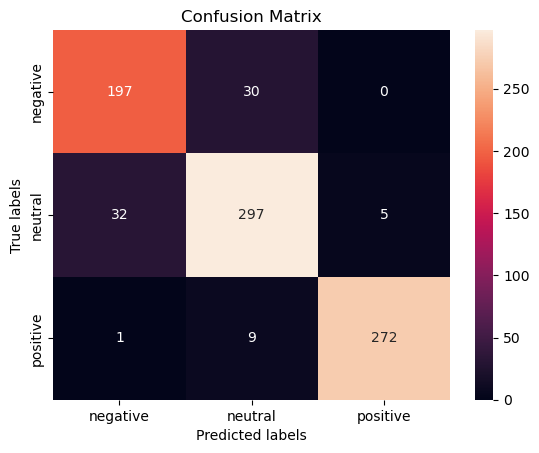

In [54]:
#Classification Report and Confusion Matrix:
print(classification_report(y_test,y_pred))
cm=confusion_matrix(y_test,y_pred)
cm
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['negative', 'neutral','positive']);
ax.yaxis.set_ticklabels(['negative', 'neutral','positive']);

In [55]:
#Model testing:
s_test = input('Enter a review: \n')
s_pred = sentiment_model.predict([s_test])
print(f'The sentiment of this review is {le.inverse_transform([s_pred[0]])}')

Enter a review: 
This hotel is a waste of money. The room was small and ugly. The bed was saggy and the sheets were scratchy. The bathroom was tiny and the water was cold. The service was slow and the staff was rude. They did not answer our calls, help our requests, or solve our problems. They also overcharged us for everything. The hotel is a scam. Do not stay here.
The sentiment of this review is ['Negative']


### Class Probability Function:

In [61]:
#Function to get proba:
def get_proba(s_test):
    s_proba = sentiment_model.predict_proba([s_test]) # Predict the probabilities for each class using the model
    classes = le.inverse_transform(sentiment_model.classes_) # Get the class labels using the label encoder
    sentiment={}
    for class_name, proba in zip(classes, s_proba[0]):
        sentiment[class_name] = round(proba*100,2)
    pol= TextBlob(s_test).polarity

    return pol,sentiment


get_proba("This hotel was fine, but not amazing. The room was cozy and quiet, but the air conditioner was noisy and the fridge was leaking. The staff was courteous and professional, but they seemed bored and uninterested. The breakfast was fresh and healthy, but it lacked variety and flavor. It was a pleasant stay, but not a spectacular one.")

(0.12272727272727271, {'Negative': 27.74, 'Neutral': 39.88, 'Positive': 32.38})

In [62]:
get_proba("This hotel is a waste of money. The room was small and ugly. The bed was saggy and the sheets were scratchy. The bathroom was tiny and the water was cold. The service was slow and the staff was rude. They did not answer our calls, help our requests, or solve our problems. They also overcharged us for everything. The hotel is a scam. Do not stay here.")

(-0.3357142857142857, {'Negative': 66.0, 'Neutral': 22.03, 'Positive': 11.97})

#### Sentiment Analysis Using Vader:

In [56]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

text="This hotel was fine, but not amazing. The room was cozy and quiet, but the air conditioner was noisy and the fridge was leaking. The staff was courteous and professional, but they seemed bored and uninterested. The breakfast was fresh and healthy, but it lacked variety and flavor. It was a pleasant stay, but not a spectacular one."

obj=SentimentIntensityAnalyzer()
obj.polarity_scores(text)

{'neg': 0.116, 'neu': 0.661, 'pos': 0.222, 'compound': 0.8398}

In [57]:
def sentiment_analyzer(text):
    dict_sent = obj.polarity_scores(text)
    return list(dict_sent.items())[:3]

In [9]:
sentiment_analyzer("This hotel is a waste of money. The room was small and ugly. The bed was saggy and the sheets were scratchy. The bathroom was tiny and the water was cold. The service was slow and the staff was rude. They did not answer our calls, help our requests, or solve our problems. They also overcharged us for everything. The hotel is a scam. Do not stay here.")

[('neg', 0.191), ('neu', 0.753), ('pos', 0.056)]

## Keywords Extraction:

#### Keywords Extraction using TF-IDF:

In [58]:
#Reviews dataframe:
df = df1[['Review']]
df.head()

Review
0  nice hotel expensive parking got good deal sta...
1  ok nothing special charge diamond member hilto...
2  nice rooms not experience hotel monaco seattle...
3  unique great stay wonderful time hotel monaco ...
4  great stay great stay went seahawk game awesom...

In [84]:
tfidf = TfidfVectorizer(max_df=0.50,         # ignore words that appear in 95% of documents
                        max_features=10000,  # the size of the vocabulary
                        ngram_range=(1,3),   # vocabulary contains single words, bigrams, trigrams
                        smooth_idf=True,     # add 1 to document frequencies to avoid dividing by zero
                        use_idf=True         # enable inverse-document-frequency reweighting
                       )
tfidf.fit(df.Review)



TfidfVectorizer(max_df=0.5, max_features=10000, ngram_range=(1, 3))

In [85]:
# Transform the first review in the dataframe into a tf-idf vector
tf_idf_vector = tfidf.transform([df.Review[0]])

# Convert the tf-idf vector into a coordinate format
tuples = zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data)

# Sort the tuples by the tf-idf value in descending order
sorted_items = sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

# Get the feature names of the words in the review
feature_names = cv.get_feature_names_out()

# Initialize two empty lists to store the values and the names of the top 10 words
score_val = []
feature_val = []

# Iterate over the sorted tuples and append the value and the name of each word to the lists
for i,score in sorted_items:
  score_val.append(round(score,3))
  feature_val.append(feature_names[i])

# Initialize an empty dictionary to store the names and the values of the top 10 words as key-value pairs
results= {}

# Iterate over the range of 10 and assign the name and the value of each word to the dictionary
for i in range(10):
  results[feature_val[i]]=score_val[i]

# Return the dictionary of the top 10 words and their tf-idf scores
results


{'parking': 0.228,
 'nice': 0.2,
 'little disappointed': 0.144,
 'nice experience': 0.143,
 'quick easy': 0.141,
 'reviews did': 0.14,
 'great walking': 0.138,
 'got good deal': 0.138,
 'soundproof': 0.137,
 'maybe just': 0.137}

In [62]:
#Function to extract keywords:
def get_keywords(id):
  tf_idf_vector=tfidf_transformer.transform(cv.transform([df.Review[id]]))
  tuples = zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data)
  sorted_items = sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
  feature_names = cv.get_feature_names_out()
  score_val = []
  feature_val = []
  for i,score in sorted_items:
    score_val.append(round(score,3))
    feature_val.append(feature_names[i])
  results= {}
  for i in range(10):
    results[feature_val[i]]=score_val[i]
  return results


In [63]:
get_keywords(10)

{'average': 0.265,
 'monaco': 0.248,
 'best western': 0.227,
 'value stayed': 0.218,
 'terribly': 0.216,
 'night not': 0.195,
 'western': 0.186,
 'wife stayed': 0.177,
 'not hotel': 0.176,
 'nicest': 0.176}

#### Keywords Extraction using KeyBERT:

KeyBERT is a minimal and easy-to-use keyword extraction technique that leverages BERT embeddings to create keywords and keyphrases that are most similar to a document.

In [64]:
from keybert import KeyBERT
bertmodel = KeyBERT(model = "distilbert-base-nli-mean-tokens")

In [65]:
bertmodel.extract_keywords(df.Review[0],top_n=20,keyphrase_ngram_range=(1,3),stop_words="english")

[('hotel expensive parking', 0.5384),
 ('nice hotel expensive', 0.4676),
 ('pay parking night', 0.4259),
 ('stay hotel anniversary', 0.4131),
 ('hotel expensive', 0.3924),
 ('expensive parking', 0.38),
 ('expensive parking got', 0.3701),
 ('deal stay hotel', 0.3259),
 ('night morning loud', 0.3245),
 ('valet parking check', 0.3107),
 ('parking night', 0.2946),
 ('parking check quick', 0.2938),
 ('hotel anniversary', 0.2923),
 ('nice size bed', 0.29),
 ('room night morning', 0.2849),
 ('nice hotel', 0.2771),
 ('hotel anniversary arrived', 0.2748),
 ('music room night', 0.2696),
 ('stay hotel', 0.2694),
 ('size bed comfortable', 0.2687)]

In [66]:
#Function to extract keywords and sentiment proba from user input review:
def get_keywords(text):
  bertmodel = KeyBERT(model = "distilbert-base-nli-mean-tokens")
  keywords = (bertmodel.extract_keywords(text,top_n=25,keyphrase_ngram_range=(1,3),stop_words="english",
                                             use_maxsum=True,use_mmr=True, diversity=0.7))

  return keywords

In [67]:
text = "The breakfast was delicious and varied, with hot and cold options, fresh fruits, pastries, and coffee.The service was friendly and helpful, from the front desk to the housekeeping.  The wifi was fast and reliable, and the business center was well-equipped.The pool and the fitness center were clean and well-maintained, and the sauna was a nice bonus."

In [68]:
get_keywords(text)

[('breakfast delicious varied', 0.6466),
 ('housekeeping wifi fast', 0.5911),
 ('fitness center clean', 0.5633),
 ('wifi fast reliable', 0.5356),
 ('sauna nice', 0.5153),
 ('clean maintained sauna', 0.5026),
 ('reliable business center', 0.5002),
 ('coffee service friendly', 0.4952),
 ('fast reliable business', 0.4849),
 ('desk housekeeping wifi', 0.4456),
 ('delicious varied hot', 0.435),
 ('options fresh fruits', 0.419),
 ('fruits pastries coffee', 0.3887),
 ('helpful desk', 0.3878),
 ('pool fitness center', 0.3733),
 ('center clean', 0.3478),
 ('breakfast', 0.3115),
 ('options fresh', 0.287),
 ('friendly helpful', 0.2752),
 ('desk housekeeping', 0.2674),
 ('wifi', 0.2161),
 ('fitness', 0.2019),
 ('pastries', 0.1836),
 ('hot cold options', 0.1761),
 ('business', 0.0623)]

### Deployment:

##### Creating pickle files:

Sentiment Analysis:

In [103]:
vec = TfidfVectorizer()
clf = LogisticRegression(solver='liblinear')
sentiment_model = Pipeline([('vectorizer',vec),('classifier',clf)])
sentiment_model.fit(X,y)

import pickle
pickle_out = open("sentiment_model.pkl",mode = "wb")
pickle.dump(sentiment_model,pickle_out)
pickle_out.close()

Keywords Extraction:

In [104]:
pickle_out = open("tfidf.pkl",mode = "wb")
pickle.dump(tfidf,pickle_out)
pickle_out.close()

In [149]:
f= open("stop.txt","r")
stopw = f.read()
stopw = stopw.split(",")
stopw.append('the')


pickle_out = open("stopwords.pkl",mode = "wb")
pickle.dump(stopw,pickle_out)
pickle_out.close()

Creating Streamlit App:

In [151]:
%%writefile app.py

# import streamlit and other necessary modules
import streamlit as st
import pickle
import string
import numpy as np
import pandas as pd
from textblob import TextBlob


pickle_in = open("sentiment_model.pkl", "rb")
sentiment_model = pickle.load(pickle_in)
pickle_in = open("tfidf.pkl", "rb")
tfidf = pickle.load(pickle_in)
pickle_in = open("stopwords.pkl", "rb")
stopw = pickle.load(pickle_in)

@st.cache_data()

def sentiment(user_input):   
    text= user_input.lower()
    text= text.translate(str.maketrans('', '', string.punctuation))
    text= text.translate(str.maketrans('', '', string.digits))
    text=' '.join(x for x in text.split() if x not in stopw)

    proba = np.round(sentiment_model.predict_proba([text])*100,2)[0]
    classes = ['Negative', 'Neutral', 'Positive']    
    df = pd.DataFrame(data=proba, index=classes, columns=['Percentage'])
    pol= TextBlob(text).polarity

    return df,pol

@st.cache_data()

def keywords(user_input):   
    text= user_input.lower()
    text= text.translate(str.maketrans('', '', string.punctuation))
    text= text.translate(str.maketrans('', '', string.digits))
    text=' '.join(x for x in text.split() if x not in stopw)
    
    tf_idf_vector = tfidf.transform([text])
    tuples = zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data)
    sorted_items = sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
    feature_names = tfidf.get_feature_names_out()
    
    score_val = []
    feature_val = []
    for i,score in sorted_items:
        score_val.append(round(score,3))
        feature_val.append(feature_names[i])
        
    results= {}
    n=len(sorted_items)
    for i in range(min(20,n)):
        results[feature_val[i]]=score_val[i]
        
    imp_words = pd.DataFrame.from_dict(results, orient='index', columns=['score']).reset_index(names='Keywords')
    imp_words

def main():
    # display the app title
    st.title("NLP - Important Keywords Extraction & Sentiment Analysis")

    # get user input as a text area widget
    user_input = st.text_area("Enter a review: ",'Type here...')

    # when the analyze button is clicked
    if st.button("Analyze"):
        df,pol = sentiment(user_input)
        st.subheader("Sentiment Analysis: ")
        st.dataframe(df)
        st.subheader("Polarity of the review is: ")
        st.write(np.round(pol,3))
        st.subheader("Important Keywords: ")
        keyword = keywords(user_input)

# run the main function
if __name__ == "__main__":
    main()

Overwriting app.py
